#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Подготовка

In [1]:
#Импорт необходимых библиотек
!pip install scikit-learn==1.1.3 -q 
!pip install statsmodels -q
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns 
import sklearn

In [2]:
#инструменты
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
TEST_SIZE = 0.25

In [3]:
#вывод общей информации о датасете
df = pd.read_csv('./taxi.csv', parse_dates=[0], index_col='datetime')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Классический временной ряд. Даты сделали индексами. Нужно расположить их в хронологическом порядке.

In [4]:
#сортировка в хронологическом порядке

df = df.sort_index(ascending=True)
print(df.index.is_monotonic_increasing)

True


Теперь это точно временной ряд.

In [5]:
#ресемплирование по 1 часу

df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Данные немного обработали.

## Анализ

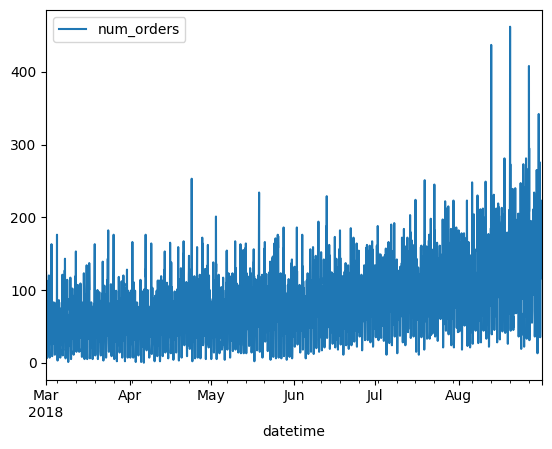

In [6]:
df.plot();

Ничего не понятно, но очень интересно. Кажется виднеется увеличение количества заказов с марта по сентябрь 2018 года. Разложим временной ряд на составляющие - тред, сезонность и остатки.

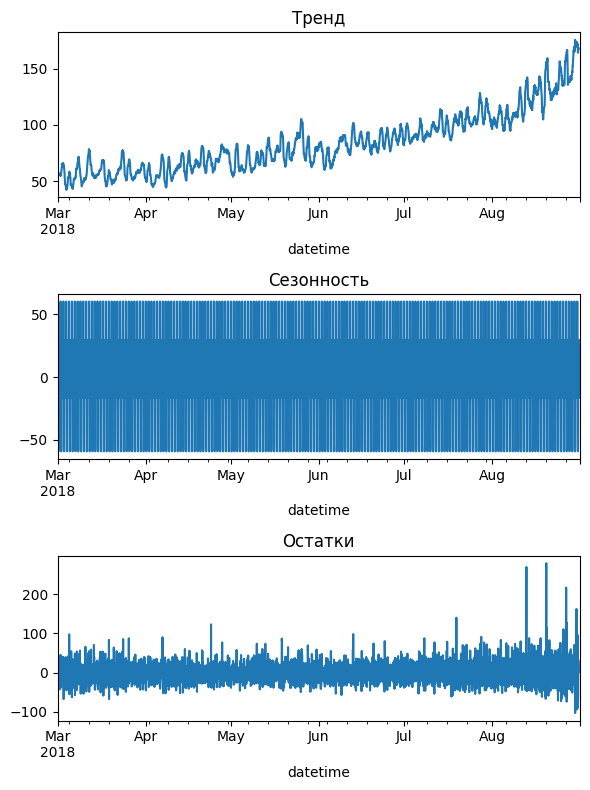

In [7]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Остатки')
plt.tight_layout()

- виднеется тренд на увеличение заказов с марта по сентябрь 2018 года;
- с сезонностью ничего неясно,  нужно рассмотреть меньшие временные промежутки;
- шум (остатки) практически не изменяются.

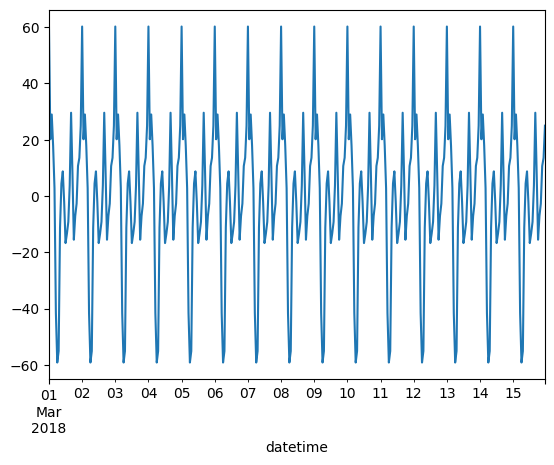

In [8]:
decomposed.seasonal['2018-03-01':'2018-03-15'].plot();

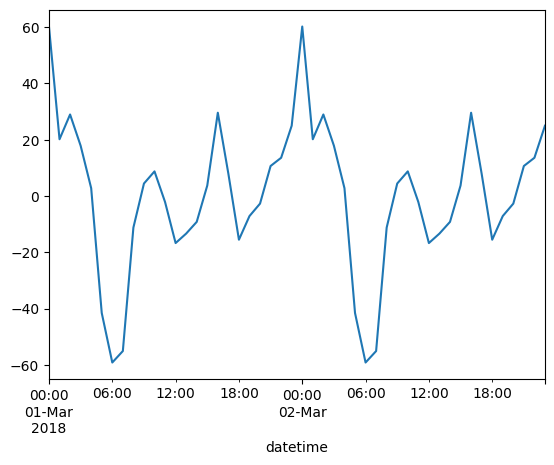

In [9]:
decomposed.seasonal['2018-03-01':'2018-03-02'].plot();

По дням наблюдается примерное одинаковое распределение заказов по часам.

Минимальное количество заказов наблюдается в 6 утра. Затем идет рост (утренние рейсы). В обед небольшое затишье, потом рост (обеденные рейся по-видимому). К 6 вечера снова наблюдается падание количества заказов. И потом резкий рост к 12 часам ночи, что является максимальным количеством заказов в день. 

## Обучение

In [10]:
#функция для создания признаков

def make_features(data, max_lag, rolling_mean_size):
    dt = data.copy()
    dt['year'] = dt.index.year
    dt['month'] = dt.index.month
    dt['day'] = dt.index.day
    dt['dayofweek'] = dt.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        dt['lag_{}'.format(lag)] = dt['num_orders'].shift(lag)

    dt['rolling_mean'] = dt['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return dt

In [11]:
data_new = make_features(df, 200, 1)

In [12]:
#разделение на тренировочную и тестовую выборки

train, test = train_test_split(data_new, shuffle=False, test_size=0.1)
train = train.dropna()
test = test.dropna()
    
X_train = train.drop(['num_orders'], axis=1) 
y_train = train['num_orders']

X_test = test.drop(['num_orders'], axis=1) 
y_test = test['num_orders']

In [13]:
# Итоговый Pipeline: модель
pipe_final = Pipeline([
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

In [14]:
# перебор гиперпараметров
param_distributions = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 10),
        'models__min_samples_leaf': range(2, 6)
    },
    {
        'models': [LinearRegression()]
    }, 
] 

In [15]:
#поиск оптимальной модели с перебором гиперпараметров
grid = GridSearchCV(
    pipe_final, 
    param_grid=param_distributions, 
    cv=TimeSeriesSplit(n_splits=5), 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1, 
)

In [16]:
#поиск лучшей модели

grid.fit(X_train, y_train);

In [17]:
print('Метрика RMSE для лучшей модели:\n', round(-grid.best_score_, 2)) 
print('\nЛучшая модель и её параметры:\n\n', grid.best_params_) 

Метрика RMSE для лучшей модели:
 22.87

Лучшая модель и её параметры:

 {'models': LinearRegression()}


In [18]:
y_pred = grid.predict(X_test)
print(f'Метрика RMSE на тестовой выборке: {round(mean_squared_error(y_test, y_pred, squared=False), 2)}')

Метрика RMSE на тестовой выборке: 35.61


In [19]:
X_test['y_pred'] = y_pred
X_test['y_test'] = y_test

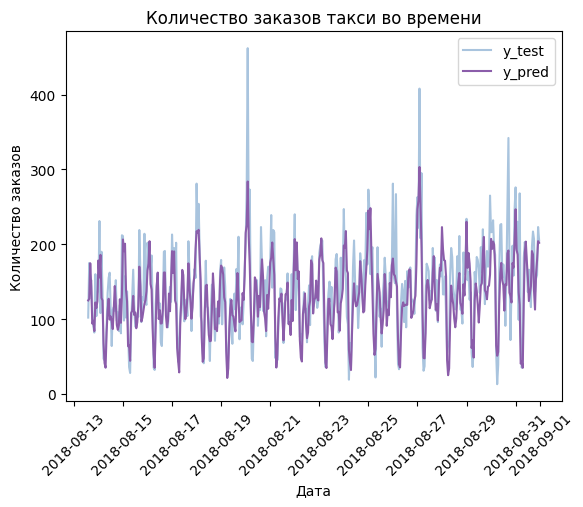

In [20]:
sns.lineplot(data=X_test[['y_test', 'y_pred']], legend='auto', dashes=False, palette='BuPu')
plt.title('Количество заказов такси во времени')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.xticks(rotation=45);

В целом предсказанные моделью значения накладываются на реальные значения.

## Выводы

В данном проекте был проанализирован временной ряд количества заказов такси у аэропорта с целью предложения модели МО для предсказания количества заказов на будушие часы.

Первоначально было проведено ресемплирование временного ряда по 1 часу. 

Были обучены две модели для задач регрессии - линейная регрессия и дерево решений. Для обучения были созданы дополнительные признаки - год, месяц, день месяца и день недели, разное количество "отстающих" значений, а также скользящее среднее.

Для дерева решения не было никакой зависимости метрики количества признаков, а значение метрики на тестовой выборке не удовлетворило условиям задачи.

Модель линейной регрессии справилась лучше. При создании 200 признаков "отстающих" значений метрика на тестовой выборке удовлетворяет условиям задачи - 35.56. 